In [1]:
# Imports
#---------
import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator, DayLocator
import matplotlib as mpl
import peakutils
import warnings
import pytz
import seaborn as sns
from scipy import stats
import copy
from scipy.stats import wilcoxon
import seaborn as sns
from matplotlib.patches import Rectangle

warnings.filterwarnings("ignore")

register_matplotlib_converters()

# File locations
#----------------
#the_gases = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/1oxaria/json/gap_filling/'
pngs = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/gap_filling/536_method/lockdown_stats/pngs/'
data_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/jun_to_sept_2021/'
stats_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/gap_filling/536_method/lockdown_stats/'
aurn_path = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/aurn/aurn_2016_2021/'


cmap = copy.copy(plt.cm.get_cmap("Blues"))
cmap.set_under("white")

def color_nan_white(val):
#     """Color the nan text white"""
    if np.isnan(val):
        return 'color: white'

def color_nan_white_background(val):
#      """Color the nan cell background white"""
    if np.isnan(val):
        return 'background-color: white'
    
def color_nonnan_black(val):
#     """Color the non-nan text white"""
    if pd.notna(val):
        return 'color: black'
    
def _color_red_or_green(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

In [2]:
# Load senssor data at 24hr resolution
#--------------------------------------
sensors_24hr = pd.read_feather(stats_home+'sensors_24hr.ftr').drop('index', axis=1)

# Load sebbes typical values 2016-21 for graphing
#-------------------------------------------------
sebbes_pm10_ld_event_desc_mean = pd.read_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10_1619.ftr')
sebbes_pm25_ld_event_desc_mean = pd.read_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25_1619.ftr')

# Load sebbes data with ordinal day & LD event codes
#-----------------------------------------------------
sebbes_ordinal_daymean_codeup_ak = pd.read_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_1619.ftr')

In [9]:
sensors_24hr['fname'].unique()

array(['County Hall', 'Divinity Road', 'High St', 'Jahlul Bayt Mosque',
       'Jesus College', 'John Radcliffe', 'New Marsten',
       'Said Business School', 'South Parks Rd', 'Speedwell St',
       'St Ebbes', 'St Giles', 'The Plain', 'Warneford Hospital',
       'Worcester College'], dtype=object)

In [3]:
# Fill gaps in data with NaNs for easy plotting - pm10
#------------------------------------------------------

sensor_ld_event_stats = sensors_24hr.groupby(['fname','ld_code']).mean().sort_values(['fname','ld_code'])
sensors = pd.DataFrame(sorted(list(sensor_ld_event_stats.index.get_level_values(0).unique())), columns=['sensor'])
events = pd.DataFrame(sorted(['a','b','c','d','e','f','g','h','i','j','k']))

tmplist = []
for i, j in sensors.iterrows():
    for ii, jj in events.iterrows():
        tmp = pd.DataFrame(zip(j,jj), columns=['sensors','events'])
        tmplist.append(tmp)
sevents = pd.concat(tmplist).reset_index(drop=True)

sensor_ld_event_stats_1 = sevents.merge(sensor_ld_event_stats.reset_index(), left_on=['sensors','events'], right_on=['fname','ld_code'], how='left')
sensor_ld_event_stats_1['ld_code'] = sensor_ld_event_stats_1['events']
sensor_ld_event_stats_1['fname'] = sensor_ld_event_stats_1['sensors']
sensor_ld_event_stats_1.drop(['sensors','events'], inplace=True, axis=1)
sensor_ld_event_stats_1.set_index('ld_code', inplace=True)

sensors_24hr

,fname,rec,pm10_count,pm10_mean,pm10_std,pm10_min,pm10_p50,pm10_p99,pm10_max,pm25_count,pm25_mean,pm25_std,pm25_min,pm25_p50,pm25_p99,pm25_max,ordinal_hrs,ordinal_days,ld_code
0,County Hall,2020-12-15 00:00:00+00:00,87.0,6.612950,1.229592,4.919706,6.440050,9.770505,12.739062,90.0,5.343533,1.428886,2.368662,5.644143,8.033531,8.089935,0,350,f
1,County Hall,2020-12-16 00:00:00+00:00,80.0,7.339553,1.004997,3.902992,7.475995,9.826809,10.219915,87.0,4.345923,1.386274,1.127552,4.390406,7.934518,8.462211,0,351,f
2,County Hall,2020-12-17 00:00:00+00:00,96.0,8.003825,1.676295,4.112205,8.221502,11.633351,12.305089,96.0,6.041280,0.938746,4.063359,5.959664,8.167700,9.206308,0,352,f
3,County Hall,2020-12-18 00:00:00+00:00,87.0,4.810527,1.701859,2.592747,4.220860,9.560819,9.567860,96.0,3.445602,1.559260,0.866599,3.054144,7.060478,8.602067,0,353,f
4,County Hall,2020-12-19 00:00:00+00:00,96.0,7.727195,2.366524,4.126148,7.044486,12.592371,12.622390,96.0,6.919402,1.979501,2.622704,6.752164,12.055009,12.941072,0,354,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6102,Worcester College,2021-09-27 00:00:00+00:00,41.0,5.782544,1.554335,3.203328,5.780949,8.702189,9.029831,49.0,3.562348,1.174231,0.650043,3.756657,5.425359,5.476766,0,270,k
6103,Worcester College,2021-09-28 00:00:00+00:00,58.0,8.334442,1.731578,3.752732,8.286094,11.972597,12.310269,61.0,5.419416,1.215315,0.995001,5.477320,8.073575,9.116414,0,271,k
6104,Worcester College,2021-09-29 00:00:00+00:00,12.0,5.580304,2.033892,3.484669,4.962007,10.031972,10.172286,14.0,2.901159,0.965911,1.510046,2.606783,4.620429,4.628774,0,272,k
6105,Worcester College,2021-09-30 00:00:00+00:00,43.0,7.241805,2.645207,3.251400,7.026726,14.314870,15.181786,51.0,3.513054,2.081902,0.600500,3.866543,7.669174,8.954279,0,273,k


In [4]:
# Create matched-paired data sensor-sebbes data for each sensor by fname & lockdown event, merging data on ordinal day
#----------------------------------------------------------------------------------------------------------------------
tmplist = []
for i, g in sensors_24hr.iloc[:,[0,1,3,7,10,14,17,18]].groupby(['fname','ld_code']):
    gg = g.merge(sebbes_ordinal_daymean_codeup_ak[['pm10_mean','pm10_99%','pm25_mean','pm25_99%','ld_code','date']].query('ld_code == @i[1]'), 
                 left_on='ordinal_days', 
                 right_on='date',
                 how='outer',
                 suffixes=(None,'_s')).rename(columns={'pm10_99%':'pm10_p99_s','pm25_99%':'pm25_p99_s'})
    tmplist.append(gg)
sensor_sebbes = pd.concat(tmplist).dropna(axis=0, subset=['rec','pm10_mean'])
sensor_sebbes.reset_index().to_feather(stats_home+'sensor_sebbes_24hr.ftr')
sensor_sebbes


,fname,rec,pm10_mean,pm10_p99,pm25_mean,pm25_p99,ordinal_days,ld_code,pm10_mean_s,pm10_p99_s,pm25_mean_s,pm25_p99_s,ld_code_s,date
0,County Hall,2020-12-15 00:00:00+00:00,6.612950,9.770505,5.343533,8.033531,350.0,f,9.027431,16.275,4.809255,13.04084,f,350
1,County Hall,2020-12-16 00:00:00+00:00,7.339553,9.826809,4.345923,7.934518,351.0,f,11.169792,19.422,7.732708,15.47626,f,351
2,County Hall,2020-12-17 00:00:00+00:00,8.003825,11.633351,6.041280,8.167700,352.0,f,12.659722,32.214,7.453292,25.83600,f,352
3,County Hall,2020-12-18 00:00:00+00:00,4.810527,9.560819,3.445602,7.060478,353.0,f,13.173958,30.658,8.572127,23.28000,f,353
4,County Hall,2020-12-19 00:00:00+00:00,7.727195,12.592371,6.919402,12.055009,354.0,f,7.965278,20.951,5.798817,18.53000,f,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Worcester College,2021-09-26 00:00:00+00:00,12.629374,29.923689,10.416576,25.616667,269.0,k,18.635417,51.661,15.073153,54.07500,k,269
98,Worcester College,2021-09-27 00:00:00+00:00,5.782544,8.702189,3.562348,5.425359,270.0,k,19.680903,52.963,14.914194,51.40700,k,270
99,Worcester College,2021-09-28 00:00:00+00:00,8.334442,11.972597,5.419416,8.073575,271.0,k,7.906250,13.532,4.218806,10.84500,k,271
100,Worcester College,2021-09-29 00:00:00+00:00,5.580304,10.031972,2.901159,4.620429,272.0,k,8.886806,23.606,5.504917,17.07700,k,272


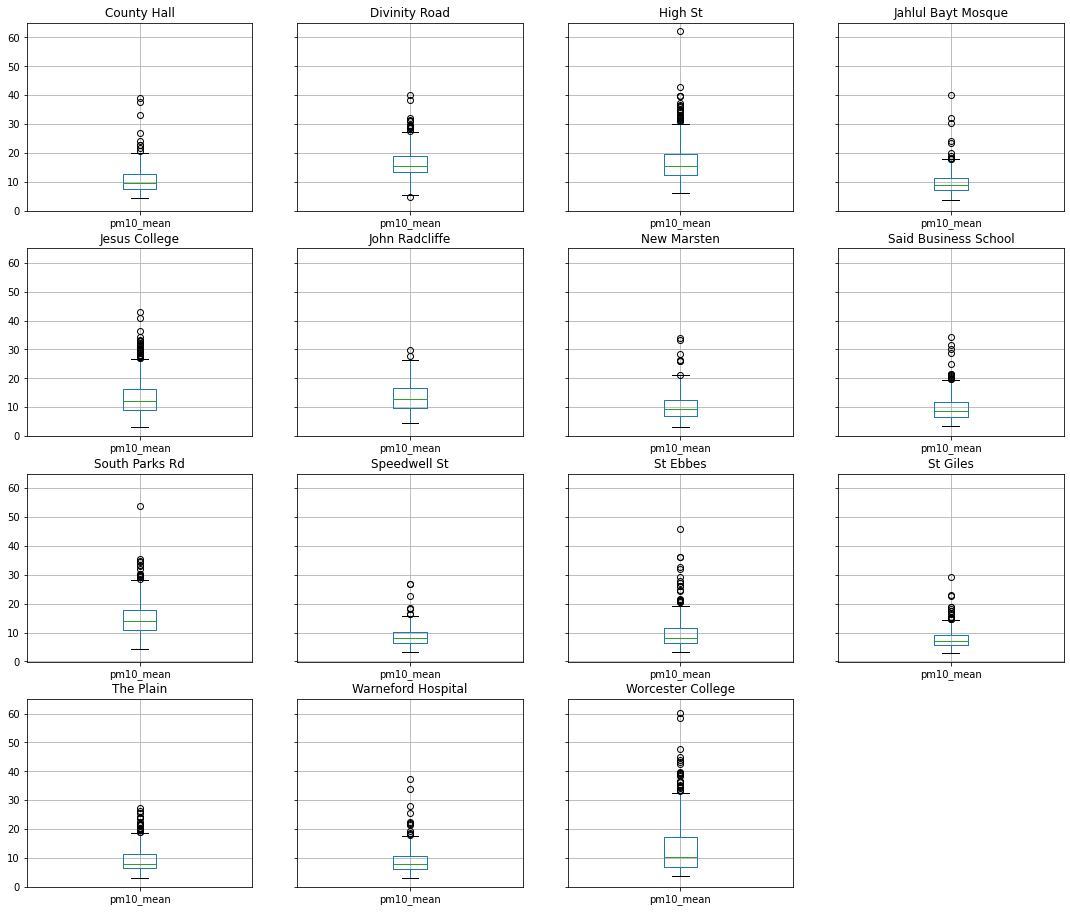

In [5]:
sensor_sebbes.groupby('fname').boxplot(column=['pm10_mean'], figsize=(18,16))
plt.show()

In [6]:
# Creat a table of differentials - pm10 mean
#---------------------------------------------
df = sensor_ld_event_stats_1.iloc[:,[0,1,2,3,4,5,6,7,8]].reset_index().merge(sebbes_pm10_ld_event_desc_mean[['ld_code','pm10_mean','pm10_99%']], 
                                                             left_on='ld_code',
                                                             right_on='ld_code',
                                                             how='left',
                                                             suffixes=(None,'_s')
                                                            ).rename(columns={'pm10_99%':'pm10_p99_s'})
df['dif_pm10_mean'] = df['pm10_mean'] - df['pm10_mean_s']
df['dif_pm10_99'] = df['pm10_p99'] - df['pm10_p99_s']

df = df.rename(columns={'ld_code': 'Event code', 'fname': 'Sensor'})
dif_pm10_mean = df[['Event code','Sensor','dif_pm10_mean']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
dif_pm10_mean.loc['Mean',:] = dif_pm10_mean.mean(axis=0)
dif_pm10_mean.loc[:,'Mean'] = dif_pm10_mean.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(g['pm10_mean'].values, g['pm10_mean_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
pm10_mean_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

dif_pm10_p99 = df[['Event code','Sensor','dif_pm10_99']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
dif_pm10_p99.loc['Mean',:] = dif_pm10_p99.mean(axis=0)
dif_pm10_p99.loc[:,'Mean'] = dif_pm10_p99.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(g['pm10_p99'].values, g['pm10_p99_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
pm10_p99_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

pm10_mean_wilcoxon_a = pm10_mean_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
pm10_mean_wilcoxon_a.loc['Mean',:] = pm10_mean_wilcoxon_a.mean(axis=0)
pm10_mean_wilcoxon_a.loc[:,'Mean'] = pm10_mean_wilcoxon_a.mean(axis=1)

pm10_p99_wilcoxon_a = pm10_p99_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
pm10_p99_wilcoxon_a.loc['Mean',:] = pm10_p99_wilcoxon_a.mean(axis=0)
pm10_p99_wilcoxon_a.loc[:,'Mean'] = pm10_p99_wilcoxon_a.mean(axis=1)

display(dif_pm10_mean.style
    .background_gradient(axis=None)
    .applymap(lambda x: color_nan_white_background(x))
    .applymap(lambda x: color_nonnan_black(x))
    .applymap(lambda x: color_nan_white(x))
         .apply(lambda x: np.where(
    pm10_mean_wilcoxon_a < 0.05,               # Compare DataFrames
    'color: red',  # True Styles
    ''                       # False Styles
), axis=None).apply(lambda x: np.where(
    pm10_mean_wilcoxon_a < 0.05,               # Compare DataFrames
    'font-weight: bold',  # True Styles
    ''                       # False Styles
), axis=None).format("{:.1f}"),
        dif_pm10_p99.style
    .background_gradient(axis=None)
    .applymap(lambda x: color_nan_white_background(x))
    .applymap(lambda x: color_nonnan_black(x))
    .applymap(lambda x: color_nan_white(x))
         .apply(lambda x: np.where(
    pm10_p99_wilcoxon_a < 0.05,               # Compare DataFrames
    'color: red',  # True Styles
    ''                       # False Styles
), axis=None).apply(lambda x: np.where(
    pm10_p99_wilcoxon_a < 0.05,               # Compare DataFrames
    'font-weight: bold',  # True Styles
    ''                       # False Styles
), axis=None).format("{:.1f}")
       )


Event code,a,b,c,d,e,f,g,h,i,j,k,Mean
Sensor,,,,,,,,,,,,
County Hall,nan,nan,nan,nan,nan,-1.8,-4.3,-5.9,-4.0,-2.8,0.5,-3.1
Divinity Road,nan,nan,5.9,3.0,5.7,3.7,0.9,2.5,2.1,2.7,4.1,3.4
High St,nan,nan,nan,6.1,8.4,3.9,1.4,5.6,4.3,1.5,4.0,4.4
Jahlul Bayt Mosque,nan,nan,-0.4,-3.4,-0.1,-1.7,-5.2,-6.6,-5.0,-3.9,-1.3,-3.1
Jesus College,-0.8,1.5,-1.2,-1.0,3.9,3.8,1.2,0.5,3.8,-1.5,-0.4,0.9
John Radcliffe,nan,nan,nan,nan,nan,2.3,-2.1,-0.7,-0.0,0.8,1.5,0.3
New Marsten,nan,nan,0.2,-1.6,4.1,-0.5,-6.2,-7.5,-6.3,-4.8,nan,-2.8
Said Business School,nan,nan,-0.7,-3.4,0.5,-1.7,-5.1,-3.9,-4.7,-2.8,-1.2,-2.6
South Parks Rd,nan,nan,3.6,-1.3,1.7,2.4,-1.1,-0.1,1.1,4.1,6.5,1.9


Event code,a,b,c,d,e,f,g,h,i,j,k,Mean
Sensor,,,,,,,,,,,,
County Hall,nan,nan,nan,nan,nan,-7.7,-18.3,-22.8,-16.8,-7.7,-3.1,-12.7
Divinity Road,nan,nan,5.5,-5.2,6.8,-0.8,-11.6,-11.9,-7.3,-2.1,3.1,-2.6
High St,nan,nan,nan,3.8,10.6,0.3,-8.9,-0.5,5.9,-1.4,3.5,1.7
Jahlul Bayt Mosque,nan,nan,-5.6,-15.4,-3.6,-7.5,-20.3,-25.6,-18.7,-9.1,-6.0,-12.4
Jesus College,-13.8,-11.2,-5.1,-10.7,3.1,-0.2,-10.5,-14.5,8.8,-4.8,-3.1,-5.6
John Radcliffe,nan,nan,nan,nan,nan,-0.2,-13.9,-13.8,-8.3,-0.3,-1.9,-6.4
New Marsten,nan,nan,-5.2,-11.9,-0.7,-5.9,-22.1,-27.1,-20.6,-12.0,nan,-13.2
Said Business School,nan,nan,-6.3,-14.7,-3.2,-7.3,-19.7,-22.2,-16.5,-7.6,-5.6,-11.5
South Parks Rd,nan,nan,1.4,-10.8,-2.8,-1.3,-13.2,-15.8,-7.5,4.9,8.6,-4.1


In [7]:
# Creat a table of differentials - pm2.5 mean
#---------------------------------------------
df = sensor_ld_event_stats_1.iloc[:,[0,8,9,10,11,12,13,14,15]].reset_index().merge(sebbes_pm25_ld_event_desc_mean[['ld_code','pm25_mean','pm25_99%']], 
                                                             left_on='ld_code',
                                                             right_on='ld_code',
                                                             how='left',
                                                             suffixes=(None,'_s')
                                                            ).rename(columns={'pm25_99%':'pm25_p99_s'})

df['dif_pm25_mean'] = df['pm25_mean'] - df['pm25_mean_s']
df['dif_pm25_99'] = df['pm25_p99'] - df['pm25_p99_s']

df = df.rename(columns={'ld_code': 'Event code', 'fname': 'Sensor'})
dif_pm25_mean = df[['Event code','Sensor','dif_pm25_mean']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
dif_pm25_mean.loc['Mean',:] = dif_pm25_mean.mean(axis=0)
dif_pm25_mean.loc[:,'Mean'] = dif_pm25_mean.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(x=g['pm25_mean'].values, y=g['pm25_mean_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
pm25_mean_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

dif_pm25_p99 = df[['Event code','Sensor','dif_pm25_99']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
dif_pm25_p99.loc['Mean',:] = dif_pm25_p99.mean(axis=0)
dif_pm25_p99.loc[:,'Mean'] = dif_pm25_p99.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(x=g['pm25_p99'].values, y=g['pm25_p99_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
pm25_p99_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

tmpdfmean = pm25_mean_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
tmpdfmean.loc['Mean',:] = tmpdfmean.mean(axis=0)
tmpdfmean.loc[:,'Mean'] = tmpdfmean.mean(axis=1)

tmpdfp99 = pm25_p99_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
tmpdfp99.loc['Mean',:] = tmpdfp99.mean(axis=0)
tmpdfp99.loc[:,'Mean'] = tmpdfp99.mean(axis=1)

display(dif_pm25_mean.style
    .background_gradient(axis=None)
    .applymap(lambda x: color_nan_white_background(x))
    .applymap(lambda x: color_nonnan_black(x))
    .applymap(lambda x: color_nan_white(x))
         .apply(lambda x: np.where(
    tmpdfmean < 0.05,               # Compare DataFrames
    'color: red',  # True Styles
    ''                       # False Styles
), axis=None).apply(lambda x: np.where(
    tmpdfmean < 0.05,               # Compare DataFrames
    'font-weight: bold',  # True Styles
    ''                       # False Styles
), axis=None).format("{:.1f}"),
        dif_pm25_p99.style
    .background_gradient(axis=None)
    .applymap(lambda x: color_nan_white_background(x))
    .applymap(lambda x: color_nonnan_black(x))
    .applymap(lambda x: color_nan_white(x))
         .apply(lambda x: np.where(
    tmpdfmean < 0.05,               # Compare DataFrames
    'color: red',  # True Styles
    ''                       # False Styles
), axis=None).apply(lambda x: np.where(
    tmpdfp99 < 0.05,               # Compare DataFrames
    'font-weight: bold',  # True Styles
    ''                       # False Styles
), axis=None).format("{:.1f}")
       )


Event code,a,b,c,d,e,f,g,h,i,j,k,Mean
Sensor,,,,,,,,,,,,
County Hall,nan,nan,nan,nan,nan,0.1,-1.8,-2.5,-1.6,-2.2,1.6,-1.1
Divinity Road,nan,nan,2.1,1.9,5.1,5.5,1.1,1.5,1.2,-0.0,2.6,2.3
High St,nan,nan,nan,5.1,6.4,5.5,1.6,3.8,1.3,-2.2,2.2,3.0
Jahlul Bayt Mosque,nan,nan,-1.2,-1.9,1.6,0.3,-2.7,-3.6,-2.4,-3.0,-0.1,-1.4
Jesus College,-2.0,0.7,-1.6,-1.0,3.1,3.6,0.5,0.3,-0.2,-2.8,0.7,0.1
John Radcliffe,nan,nan,nan,nan,nan,2.1,-1.8,-1.9,-2.3,-3.4,-0.0,-1.2
New Marsten,nan,nan,-1.0,-2.1,3.2,0.5,-4.1,-4.3,-3.8,-4.0,nan,-1.9
Said Business School,nan,nan,-1.3,-2.7,2.3,0.4,-2.8,0.5,-3.1,-2.8,-0.5,-1.1
South Parks Rd,nan,nan,0.3,-2.1,2.2,3.6,-0.5,-0.5,-0.4,0.0,3.9,0.7


Event code,a,b,c,d,e,f,g,h,i,j,k,Mean
Sensor,,,,,,,,,,,,
County Hall,nan,nan,nan,nan,nan,-3.9,-13.2,-17.1,-14.7,-8.7,-1.1,-9.8
Divinity Road,nan,nan,-0.8,-5.0,2.3,6.1,-9.3,-12.3,-10.8,-4.9,0.4,-3.8
High St,nan,nan,nan,-1.6,0.5,2.5,-9.8,-9.0,-8.8,-8.0,-1.2,-4.4
Jahlul Bayt Mosque,nan,nan,-5.8,-12.7,-4.1,-4.1,-15.1,-19.1,-15.8,-9.2,-4.7,-10.1
Jesus College,-13.1,-14.2,-5.6,-7.4,-0.5,2.2,-10.1,-13.2,-10.3,-9.0,-2.0,-7.6
John Radcliffe,nan,nan,nan,nan,nan,0.8,-12.2,-13.1,-12.3,-9.0,-3.7,-8.2
New Marsten,nan,nan,-5.5,-12.7,-2.6,-2.9,-17.2,-20.3,-16.7,-10.6,nan,-11.1
Said Business School,nan,nan,-6.1,-13.2,-2.2,-3.2,-14.6,-14.0,-14.8,-8.8,-4.9,-9.1
South Parks Rd,nan,nan,-3.7,-10.0,-1.5,2.9,-10.3,-14.7,-12.2,-3.8,2.9,-5.6


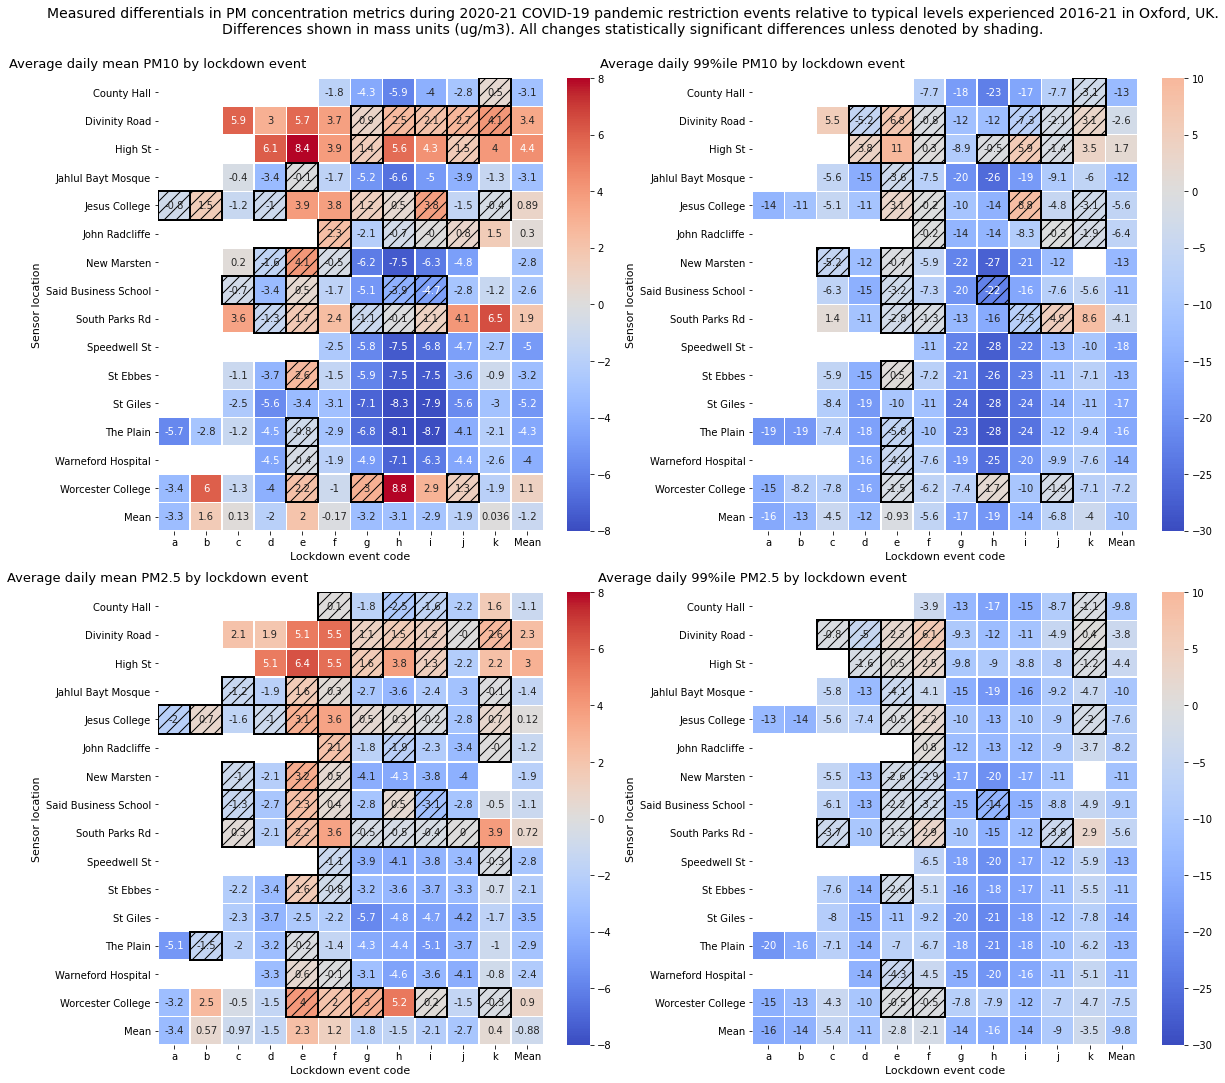

In [15]:
# Heat map analysis
#-------------------
fig, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2,2, figsize=(17,15))

sns.heatmap(dif_pm10_mean, annot=True, cmap='coolwarm', robust=True, ax=ax1, linewidths=.5, vmin=-8, vmax=8)
tmpdf = pm10_mean_wilcoxon[['fname','ld_code', 'P'
                          ]].pivot(index='fname',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax1.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))

sns.heatmap(dif_pm10_p99, annot=True, cmap='coolwarm', robust=True, ax=ax2, linewidths=.5, center=0, vmin=-30, vmax=10)
tmpdf = pm10_p99_wilcoxon[['fname','ld_code', 'P'
                          ]].pivot(index='fname',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax2.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))

# pm2.5
#-------
sns.heatmap(dif_pm25_mean, annot=True, cmap='coolwarm', robust=True, ax=ax3, linewidths=.5, vmin=-8, vmax=8)
tmpdf = pm25_mean_wilcoxon[['fname','ld_code', 'P'
                          ]].pivot(index='fname',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax3.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))

sns.heatmap(dif_pm25_p99, annot=True, cmap='coolwarm', robust=True, ax=ax4, linewidths=.5, center=0, vmin=-30, vmax=10)
tmpdf = pm25_p99_wilcoxon[['fname','ld_code', 'P'
                          ]].pivot(index='fname',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax4.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))
    
ax1.set_title('Average daily mean PM10 by lockdown event', y=1.01, x=0, fontsize=13)    
ax2.set_title('Average daily 99%ile PM10 by lockdown event', y=1.01, x=0, fontsize=13)    
ax3.set_title('Average daily mean PM2.5 by lockdown event', y=1.01, x=0, fontsize=13)
ax4.set_title('Average daily 99%ile PM2.5 by lockdown event', y=1.01, x=0, fontsize=13)
ax1.set_xlabel('Lockdown event code', fontsize=11)
ax1.set_ylabel('Sensor location', fontsize=11)
ax2.set_xlabel('Lockdown event code', fontsize=11)
ax2.set_ylabel('Sensor location', fontsize=11)
ax3.set_xlabel('Lockdown event code', fontsize=11)
ax3.set_ylabel('Sensor location', fontsize=11)
ax4.set_xlabel('Lockdown event code', fontsize=11)
ax4.set_ylabel('Sensor location', fontsize=11)

fig.suptitle('Measured differentials in PM concentration metrics during 2020-21 COVID-19 pandemic restriction events relative to typical levels experienced 2016-21 in Oxford, UK.\nDifferences shown in mass units (ug/m3). All changes statistically significant differences unless denoted by shading.', fontsize=14, y=1)

plt.tight_layout() 
plt.savefig(stats_home+'sensor_vs_typical_year_heatmap_24hrmean_p99_1619.png')

plt.show()

    


In [25]:
dif_pm10_p99.describe().round()

Event code,a,b,c,d,e,f,g,h,i,j,k,Mean
count,4.0,4.0,11.0,13.0,13.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0
mean,-16.0,-13.0,-4.0,-12.0,-1.0,-6.0,-17.0,-19.0,-14.0,-7.0,-4.0,-10.0
std,2.0,5.0,4.0,6.0,5.0,4.0,5.0,9.0,10.0,5.0,5.0,6.0
min,-19.0,-19.0,-8.0,-19.0,-10.0,-11.0,-24.0,-28.0,-24.0,-14.0,-11.0,-18.0
25%,-17.0,-14.0,-7.0,-16.0,-4.0,-8.0,-21.0,-26.0,-21.0,-11.0,-7.0,-13.0
50%,-15.0,-12.0,-6.0,-15.0,-2.0,-7.0,-19.0,-22.0,-17.0,-8.0,-6.0,-12.0
75%,-15.0,-10.0,-5.0,-11.0,0.0,-1.0,-13.0,-14.0,-8.0,-2.0,-2.0,-6.0
max,-14.0,-8.0,6.0,4.0,11.0,0.0,-7.0,2.0,9.0,5.0,9.0,2.0


In [9]:
# Creat a table of differentials - pm10 percentages
#---------------------------------------------------
df = sensor_ld_event_stats_1.iloc[:,[0,1,2,3,4,5,6,7,8]].reset_index().merge(sebbes_pm10_ld_event_desc_mean[['ld_code','pm10_mean','pm10_99%']], 
                                                             left_on='ld_code',
                                                             right_on='ld_code',
                                                             how='left',
                                                             suffixes=(None,'_s')
                                                            ).rename(columns={'pm10_99%':'pm10_p99_s'})
df['pdif_pm10_mean'] = (( df['pm10_mean'] - df['pm10_mean_s'] ) / df['pm10_mean_s'] ) * 100
df['pdif_pm10_99'] = (( df['pm10_p99'] - df['pm10_p99_s'] ) / df['pm10_p99_s'] ) * 100

df = df.rename(columns={'ld_code': 'Event code', 'fname': 'Sensor'})
pdif_pm10_mean = df[['Event code','Sensor','pdif_pm10_mean']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
pdif_pm10_mean.loc['Mean',:] = pdif_pm10_mean.mean(axis=0)
pdif_pm10_mean.loc[:,'Mean'] = pdif_pm10_mean.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(g['pm10_mean'].values, g['pm10_mean_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
ppm10_mean_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

pdif_pm10_p99 = df[['Event code','Sensor','pdif_pm10_99']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
pdif_pm10_p99.loc['Mean',:] = pdif_pm10_p99.mean(axis=0)
pdif_pm10_p99.loc[:,'Mean'] = pdif_pm10_p99.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(g['pm10_p99'].values, g['pm10_p99_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
ppm10_p99_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

ppm10_mean_wilcoxon_a = pm10_mean_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
ppm10_mean_wilcoxon_a.loc['Mean',:] = ppm10_mean_wilcoxon_a.mean(axis=0)
ppm10_mean_wilcoxon_a.loc[:,'Mean'] = ppm10_mean_wilcoxon_a.mean(axis=1)

ppm10_p99_wilcoxon_a = pm10_p99_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
ppm10_p99_wilcoxon_a.loc['Mean',:] = ppm10_p99_wilcoxon_a.mean(axis=0)
ppm10_p99_wilcoxon_a.loc[:,'Mean'] = ppm10_p99_wilcoxon_a.mean(axis=1)


# Creat a table of differentials - pm2.5 percentages
#----------------------------------------------------
df = sensor_ld_event_stats_1.iloc[:,[0,8,9,10,11,12,13,14,15]].reset_index().merge(sebbes_pm25_ld_event_desc_mean[['ld_code','pm25_mean','pm25_99%']], 
                                                             left_on='ld_code',
                                                             right_on='ld_code',
                                                             how='left',
                                                             suffixes=(None,'_s')
                                                            ).rename(columns={'pm25_99%':'pm25_p99_s'})

df['pdif_pm25_mean'] = (( df['pm25_mean'] - df['pm25_mean_s'] ) / df['pm25_mean_s'] ) * 100
df['pdif_pm25_99'] = (( df['pm25_p99'] - df['pm25_p99_s'] ) / df['pm25_p99_s'] ) * 100

df = df.rename(columns={'ld_code': 'Event code', 'fname': 'Sensor'})
pdif_pm25_mean = df[['Event code','Sensor','pdif_pm25_mean']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
pdif_pm25_mean.loc['Mean',:] = pdif_pm25_mean.mean(axis=0)
pdif_pm25_mean.loc[:,'Mean'] = pdif_pm25_mean.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(x=g['pm25_mean'].values, y=g['pm25_mean_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
ppm25_mean_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

pdif_pm25_p99 = df[['Event code','Sensor','pdif_pm25_99']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
pdif_pm25_p99.loc['Mean',:] = pdif_pm25_p99.mean(axis=0)
pdif_pm25_p99.loc[:,'Mean'] = pdif_pm25_p99.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(x=g['pm25_p99'].values, y=g['pm25_p99_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
ppm25_p99_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

ptmpdfmean = pm25_mean_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
ptmpdfmean.loc['Mean',:] = ptmpdfmean.mean(axis=0)
ptmpdfmean.loc[:,'Mean'] = ptmpdfmean.mean(axis=1)

ptmpdfp99 = pm25_p99_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
ptmpdfp99.loc['Mean',:] = ptmpdfp99.mean(axis=0)
ptmpdfp99.loc[:,'Mean'] = ptmpdfp99.mean(axis=1)


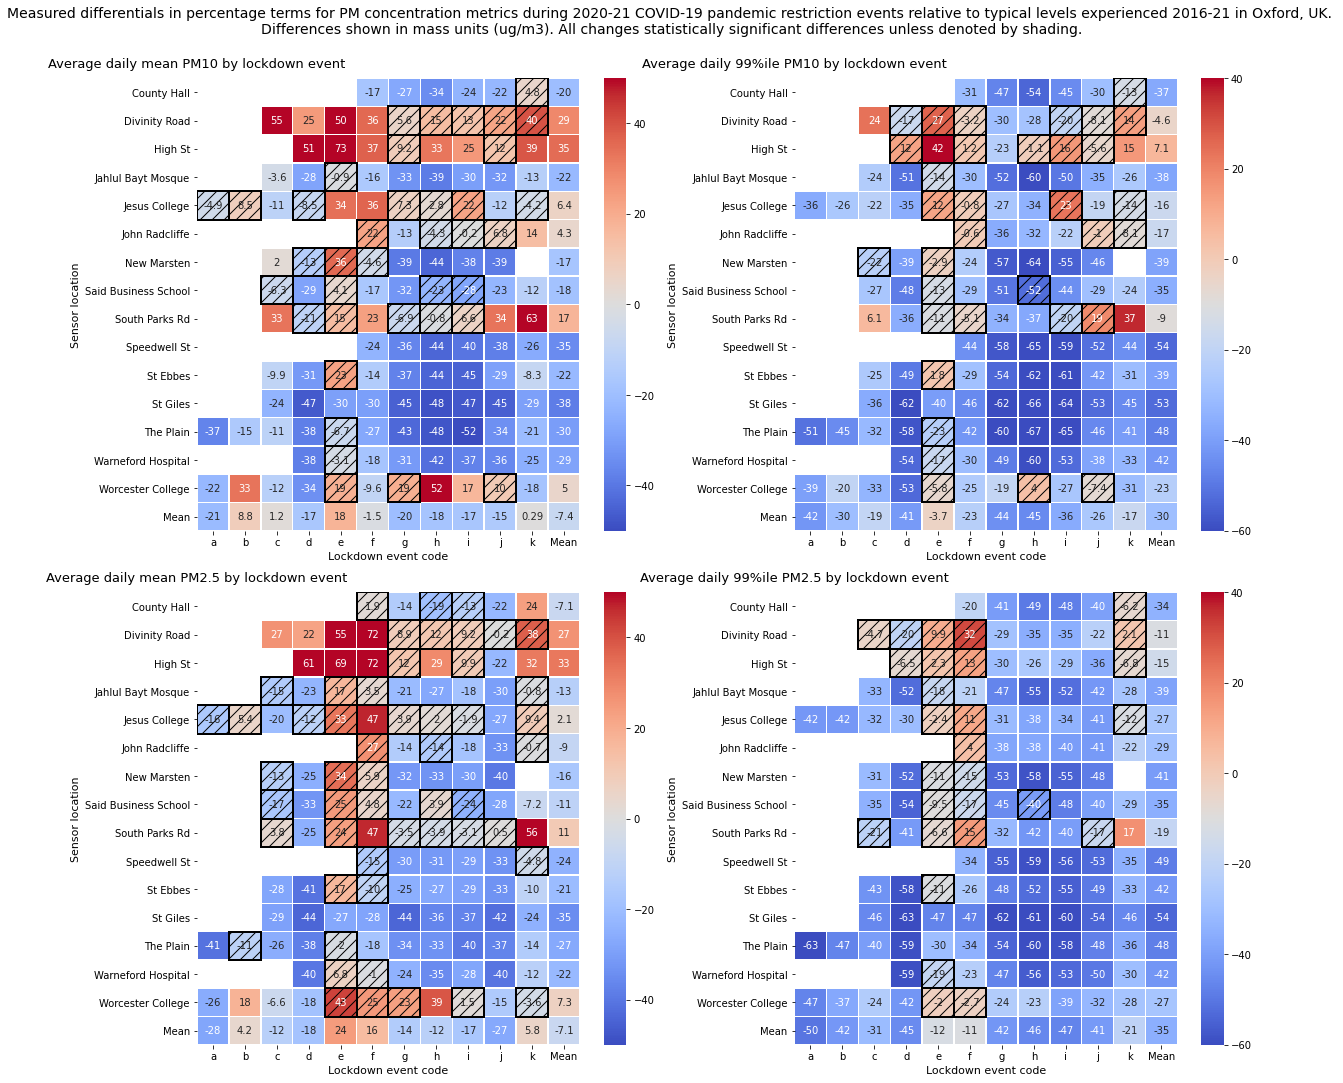

In [10]:
# Heat map analysis - percentages
#---------------------------------
fig, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2,2, figsize=(17,15))

# pm10
#------
sns.heatmap(pdif_pm10_mean, annot=True, cmap='coolwarm', robust=True, ax=ax1, linewidths=.5, vmin=-50, vmax=50)
tmpdf = pm10_mean_wilcoxon[['fname','ld_code', 'P'
                          ]].pivot(index='fname',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax1.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))

sns.heatmap(pdif_pm10_p99, annot=True, cmap='coolwarm', robust=True, ax=ax2, linewidths=.5, vmin=-60, vmax=40)
tmpdf = pm10_p99_wilcoxon[['fname','ld_code', 'P'
                          ]].pivot(index='fname',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax2.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))

# pm2.5
#-------
sns.heatmap(pdif_pm25_mean, annot=True, cmap='coolwarm', robust=True, ax=ax3, linewidths=.5, vmin=-50, vmax=50)
tmpdf = pm25_mean_wilcoxon[['fname','ld_code', 'P'
                          ]].pivot(index='fname',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax3.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))

sns.heatmap(pdif_pm25_p99, annot=True, cmap='coolwarm', robust=True, ax=ax4, linewidths=.5, vmin=-60, vmax=40)
tmpdf = pm25_p99_wilcoxon[['fname','ld_code', 'P'
                          ]].pivot(index='fname',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax4.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))
    
ax1.set_title('Average daily mean PM10 by lockdown event', y=1.01, x=0, fontsize=13)    
ax2.set_title('Average daily 99%ile PM10 by lockdown event', y=1.01, x=0, fontsize=13)    
ax3.set_title('Average daily mean PM2.5 by lockdown event', y=1.01, x=0, fontsize=13)
ax4.set_title('Average daily 99%ile PM2.5 by lockdown event', y=1.01, x=0, fontsize=13)
ax1.set_xlabel('Lockdown event code', fontsize=11)
ax1.set_ylabel('Sensor location', fontsize=11)
ax2.set_xlabel('Lockdown event code', fontsize=11)
ax2.set_ylabel('Sensor location', fontsize=11)
ax3.set_xlabel('Lockdown event code', fontsize=11)
ax3.set_ylabel('Sensor location', fontsize=11)
ax4.set_xlabel('Lockdown event code', fontsize=11)
ax4.set_ylabel('Sensor location', fontsize=11)

fig.suptitle('Measured differentials in percentage terms for PM concentration metrics during 2020-21 COVID-19 pandemic restriction events relative to typical levels experienced 2016-21 in Oxford, UK. \nDifferences shown in mass units (ug/m3). All changes statistically significant differences unless denoted by shading.', fontsize=14, y=1)

plt.tight_layout() 
plt.savefig(stats_home+'sensor_vs_typical_year_heatmap_24hrmean_p99_%_1619.png')

plt.show()

    
